# data586 Mini Project 2: Twitter Gender Classification

# Team Member: Jae Yoon Cho

## Dataset
- https://www.kaggle.com/crowdflower/twitter-user-gender-classification
- The dataset contains 20,000 rows, each with a user name, a random tweet, account profile and image, location, and even link and sidebar color.

### Labels:
- unitid: a unique id for user
- _golden: whether the user was included in the gold standard for the model; TRUE or FALSE
- unitstate: state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)
- trustedjudgments: number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations
- lastjudgment_at: date and time of last contributor judgment; blank for gold standard observations
- gender: one of male, female, or brand (for non-human profiles)
- gender:confidence: a float representing confidence in the provided gender
- profile_yn: "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it
- profile_yn:confidence: confidence in the existence/non-existence of the profile
- created: date and time when the profile was created
- description: the user's profile description
- fav_number: number of tweets the user has favorited
- gender_gold: if the profile is golden, what is the gender?
- link_color: the link color on the profile, as a hex value
- name: the user's name
- profileyngold: whether the profile y/n value is golden
- profileimage: a link to the profile image
- retweet_count: number of times the user has retweeted (or possibly, been retweeted)
- sidebar_color: color of the profile sidebar, as a hex value
- text: text of a random one of the user's tweets
- tweet_coord: if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"
- tweet_count: number of tweets that the user has posted
- tweet_created: when the random tweet (in the text column) was created
- tweet_id: the tweet id of the random tweet
- tweet_location: location of the tweet; seems to not be particularly normalized
- user_timezone: the timezone of the user

## Main Goal
- The main purpose of this project is to classify twitter user genders using neural networks

## Methodology

1. Load the dataset
2. Exploratory Data Analysis
    - I will use only description for gender classification because I think the user's profile description is the best way to classify gender
3. Building a model
    - For this step, I will train the model with gender and description data. 
    - Using tokenizer will allow to modify test to integer
    - After that, I will develop text data to sequence and vertorize using pad_sequences
    - Declaring Sequential(), I will build model step by step using model.add() to add Embedding, LSTM, Dense. 
    - In order to avoid overfitting, I need to implement dropout
4. Check the Accuracy rate

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### EDA

In [2]:
df = pd.read_csv('gender-classifier-DFE-791531.csv', delimiter=',', encoding='latin-1')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [3]:
df = df[['gender', 'description']]

In [4]:
df.head()

,gender,description
0,male,i sing my own rhythm.
1,male,I'm the author of novels filled with family dr...
2,male,louis whining and squealing and all
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe..."
4,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...


In [5]:
import missingno as msno

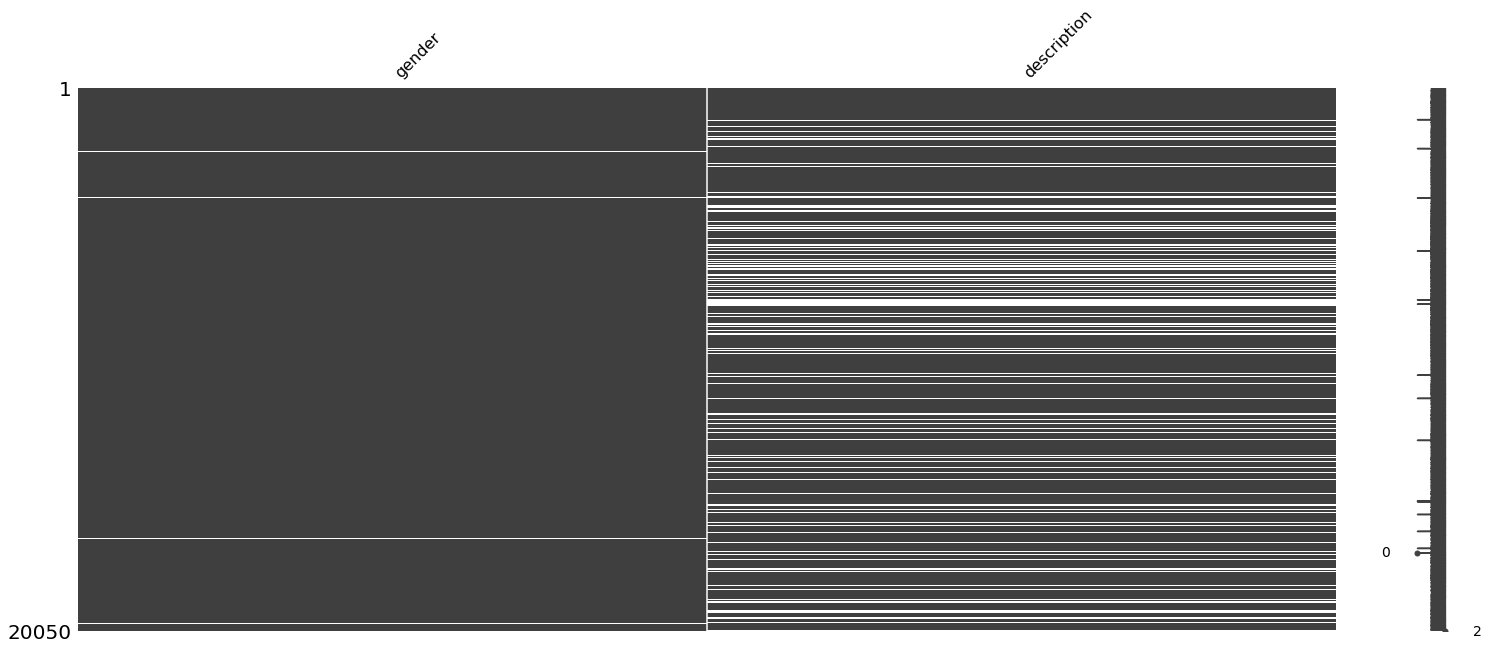

In [6]:
msno.matrix(df)

In [8]:
df = df.dropna()

Text(0.5, 1.0, 'Male vs. Female')

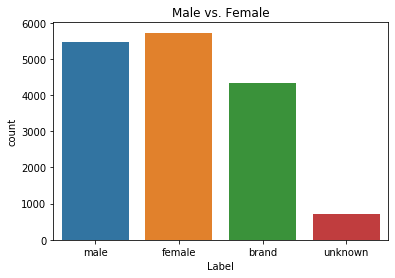

In [10]:
sns.countplot(df.gender)
plt.xlabel("Label")
plt.title("Male vs. Female")

In [13]:
df.drop(df.loc[df['gender']=='brand'].index, inplace=True)
df.drop(df.loc[df['gender']=='unknown'].index, inplace=True)

Text(0.5, 1.0, 'Male vs. Female')

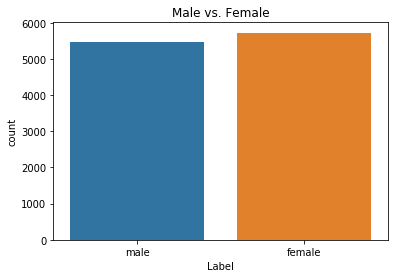

In [14]:
sns.countplot(df.gender)
plt.xlabel("Label")
plt.title("Male vs. Female")

### Building a Model

In [16]:
x = df.description.values
y = df.gender.values
print(type(x))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
le = LabelEncoder()
y = le.fit_transform(y)
print(y)
print(y.shape)
print(x.shape)

[1 1 1 ... 1 0 0]
(11194,)
(11194,)


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [19]:
# I am using 10000 most used words. Since all of the lengths of sms are different, it is wise to limit lengths.  
max_num_words = 10000 # top 10000 words
max_limit = 200 # limit 200 lengths
tok = Tokenizer(num_words = max_num_words)
tok.fit_on_texts(x_train)

In [20]:
seq = tok.texts_to_sequences(x_train) 

In [21]:
seq_limit = sequence.pad_sequences(seq, maxlen=max_limit)

In [22]:
model = Sequential()
model.add(Embedding(max_num_words, 100, input_length=max_limit))
model.add(LSTM(64))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 1,059,137
Trainable params: 1,059,137
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(seq_limit, 
                    y_train, 
                    batch_size=128, 
                    epochs=10, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])


//anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7164 samples, validate on 1791 samples
Epoch 1/10
7164/7164 [==============================] - 12s 2ms/step - loss: 0.6857 - accuracy: 0.5532 - val_loss: 0.6626 - val_accuracy: 0.6086
Epoch 2/10
7164/7164 [==============================] - 12s 2ms/step - loss: 0.5578 - accuracy: 0.7217 - val_loss: 0.6413 - val_accuracy: 0.6544
Epoch 3/10
7164/7164 [==============================] - 11s 2ms/step - loss: 0.3605 - accuracy: 0.8428 - val_loss: 0.7458 - val_accuracy: 0.6404
Epoch 4/10
7164/7164 [==============================] - 12s 2ms/step - loss: 0.2438 - accuracy: 0.9006 - val_loss: 0.9302 - val_accuracy: 0.6477
Epoch 5/10
7164/7164 [==============================] - 13s 2ms/step - loss: 0.1594 - accuracy: 0.9338 - val_loss: 1.1179 - val_accuracy: 0.6376
Epoch 6/10
7164/7164 [==============================] - 12s 2ms/step - loss: 0.1212 - accuracy: 0.9493 - val_loss: 1.4482 - val_accuracy: 0.6164
Epoch 7/10
7164/7164 [==============================] - 12s 2ms/step - loss: 0.102

### Model Evaluation

In [26]:
Xtest = tok.texts_to_sequences(x_test)
Xtest = sequence.pad_sequences(Xtest, maxlen=max_limit)
loss, acc = model.evaluate(Xtest, y_test)
print("\nLoss: {}, Accuracy Rate: {}".format(loss, acc))

2239/2239 [==============================] - 1s 430us/step

Loss: 2.1320801975472583, Accuracy Rate: 0.6020544767379761


### Conclusion
- It is not really accurate to use only description for classifying genders in Twitter Data because the accuracy rate is only 60%.